Random Forest Regression (Kristin)
1.  Model #1: default parameters
2.  Model #2:  add max_sample_leafs
3.  Model #3:  increase n_estimators and decrease max_sample_leafs




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



vgsales = pd.read_excel('vgsales_v5.xlsx')

vgsales.head()

# Create dummy variables for | Genre | First_Party | Platform_Type

#dummy variables for Genre
dummy_genre = pd.get_dummies(vgsales.Genre)
dummy_genre

#dummy variables for First Party
dummy_first_party = pd.get_dummies(vgsales.First_Party)
dummy_first_party

#dummy variables for Platform Type
dummy_platform_type = pd.get_dummies(vgsales.Platform_Type)
dummy_platform_type

#Merge dummy frames into one dataset with original vgsales datframe
merged_vgsales = pd.concat([vgsales, dummy_genre, dummy_first_party, dummy_platform_type], axis='columns')






In [2]:
vgsales_df = pd.DataFrame(merged_vgsales)



In [3]:
#drop Rank (it is perfectly correlated with sales because it is based on global sales & is a result of sales
# drop Name (a significant number of dummy variables would have to be created and we are not analyzing the impact of name, but trying to understand impact of genre, platform and region on sales)
#drop Platform (we have created Platform Type and First Parties categories that are more meaningful than Platform)
#drop Publisher (similar reason as Name)

vgsales_df2 = vgsales_df.drop(columns = ["Rank","Name", "Platform", "Publisher","Genre", "First_Party", "Platform_Type","Year_1_Sales", "Year", "Atari","SEGA", "Other","EU_Sales", "Other_Sales","Avg_Annual_Sales","JP_Sales", "NA_Sales"])

In [4]:
#Create X, y

X = vgsales_df2.drop(columns = "Global_Sales")
y = vgsales_df2.Global_Sales

In [5]:
#create test/train/validation sets, 80% = train, 10% = test, 10% = validation
#check shape to ensure similar sizes 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(12783, 19)
(12783,)
(1598, 19)
(1598,)
(1598, 19)
(1598,)


Random Forest

In [6]:
#import libraries for random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import timeit
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score



In [7]:
#Model #1:  using default parameters, except i set n_estimators to 100 to avoid pink error

rnd_reg1 = RandomForestRegressor(n_estimators = 100)
rnd_reg1.fit(X_train, y_train)

y_pred_rf1 = rnd_reg1.predict(X_val)
print("mse:",mean_squared_error(y_val, y_pred_rf1))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred_rf1)))
print("r-squared:", r2_score(y_val, y_pred_rf1))
print("training time:", timeit.timeit())

#good results, low rmse and hight r-squares


mse: 2.4459231762408717
rmse: 1.5639447484616813
r-squared: -0.18706953084826794
training time: 0.009925899999999821


In [8]:
#Model #2:  keep n_estimators at 100, set max_leaf_nodes to 16

rnd_reg2 = RandomForestRegressor(n_estimators = 100, max_leaf_nodes = 16)
rnd_reg2.fit(X_train, y_train)

y_pred_rf2 = rnd_reg2.predict(X_val)
print("mse:",mean_squared_error(y_val, y_pred_rf2))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred_rf2)))
print("r-squared:", r2_score(y_val, y_pred_rf2))
print("training time:", timeit.timeit())

#good results, but not as good as #1

mse: 2.250128038182891
rmse: 1.5000426787871375
r-squared: -0.09204510615064998
training time: 0.00769419999999954


In [9]:
#Model #3:   n_estimators at 500 and max_leaf_nodes to 5

rnd_reg3 = RandomForestRegressor(n_estimators = 500, max_leaf_nodes = 5)
rnd_reg3.fit(X_train, y_train)

y_pred_rf3 = rnd_reg3.predict(X_val)
print("mse:",mean_squared_error(y_val, y_pred_rf3))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred_rf3)))
print("r-squared:", r2_score(y_val, y_pred_rf3))
print("training time:", timeit.timeit())

#slower than other models and the worst results, stick with model 1, default parameters with n_estimators set to 100

mse: 2.058360627253414
rmse: 1.4346987932152917
r-squared: 0.0010245588066531974
training time: 0.007465500000000347


In [10]:
#run random forest based on article https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

rf4 = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf4.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf4.score(X_train, y_train), 
                                                                                             rf4.oob_score_,
                                                                                             rf4.score(X_val, y_val)))
y_pred_rf4 = rf4.predict(X_val)
print("mse:",mean_squared_error(y_val, y_pred_rf4))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred_rf4)))
print("r-squared:", r2_score(y_val, y_pred_rf4))
print("training time:", timeit.timeit())


R^2 Training Score: 0.22 
OOB Score: -0.12 
R^2 Validation Score: -0.19
mse: 2.4470730450768947
rmse: 1.5643123233794762
r-squared: -0.18762759181803745
training time: 0.007799700000001408


In [11]:
#permutation importances
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf4, X_train, y_train):
    return r2_score(y_train, rf4.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf4, X_train, y_train, r2)

perm_imp_rfpimp


,Importance
Feature,
Years_In_Market,0.573835
Shooter,0.143150
Nintendo,0.089267
Console,0.087441
Action,0.059373
HH,0.051148
Role-Playing,0.043355
Adventure,0.031059
Simulation,0.027700


Automatically created module for IPython interactive environment
Feature ranking:
1. feature 0 (0.616977)
2. feature 13 (0.050671)
3. feature 8 (0.049438)
4. feature 7 (0.037109)
5. feature 5 (0.031858)
6. feature 10 (0.026599)
7. feature 17 (0.026041)
8. feature 6 (0.024109)
9. feature 1 (0.022872)
10. feature 3 (0.022382)
11. feature 2 (0.021935)
12. feature 16 (0.018755)
13. feature 9 (0.011777)
14. feature 4 (0.010936)
15. feature 11 (0.009492)
16. feature 15 (0.007204)
17. feature 12 (0.005578)
18. feature 18 (0.003166)
19. feature 14 (0.003099)


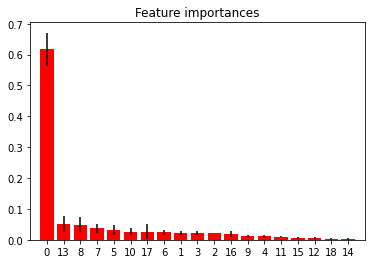

In [12]:
#the example in book uses classification, need to change the below to regression
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor

labels = vgsales_df2.drop(columns = ["Global_Sales"])


# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()